In [1]:
 # Celda 1: Imports y helpers
import math, json, os, sys, time, random
import numpy as np
import pandas as pd

R_EARTH_KM = 6371.0088

def haversine_km(lat1, lon1, lat2, lon2):
    """Distancia Haversine (km). Entradas en grados."""
    φ1, φ2 = math.radians(lat1), math.radians(lat2)
    Δφ = math.radians(lat2 - lat1)
    Δλ = math.radians(lon2 - lon1)
    a = math.sin(Δφ/2)**2 + math.cos(φ1)*math.cos(φ2)*math.sin(Δλ/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R_EARTH_KM * c

def ensure_cols(df, cols, name):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"{name}: faltan columnas {missing}. Columnas encontradas: {list(df.columns)}")

pd.set_option("display.max_columns", 50)


In [3]:
# Celda 2: Cargar datos
CLIENTS_CSV    = "clients.csv"
DEPOTS_CSV     = "depots.csv"
VEHICLES_CSV   = "vehicles.csv"
PARAMS_CSV     = "parameters_base.csv"   # se cambiar a parameters_A_caso2.csv / caso3.csv luego

clients   = pd.read_csv(CLIENTS_CSV)
depots    = pd.read_csv(DEPOTS_CSV)
vehicles  = pd.read_csv(VEHICLES_CSV)
params_df = pd.read_csv(PARAMS_CSV, comment="#")  # ignora líneas que empiezan con '#'

# Validar esquema esperado
ensure_cols(clients,  ["ClientID","StandardizedID","LocationID","Latitude","Longitude","Demand"], "clients.csv")
ensure_cols(depots,   ["DepotID","StandardizedID","LocationID","Longitude","Latitude"],             "depots.csv")
ensure_cols(vehicles, ["VehicleID","StandardizedID","Capacity","Range"],                           "vehicles.csv")
ensure_cols(params_df,["Parameter","Value","Unit","Description"],                                  "parameters_base.csv")

clients.head(), depots.head(), vehicles.head(), params_df.head()


(   ClientID StandardizedID  LocationID  Latitude  Longitude  Demand
 0         1           C001           2  4.597954 -74.098938      13
 1         2           C002           3  4.687821 -74.075571      15
 2         3           C003           4  4.709494 -74.107085      12
 3         4           C004           5  4.605029 -74.097280      15
 4         5           C005           6  4.648464 -74.164641      20,
    DepotID StandardizedID  LocationID  Longitude  Latitude
 0        1           CD01           1 -74.153536  4.743359,
    VehicleID StandardizedID  Capacity  Range
 0          1           V001       130    170
 1          2           V002       140    200
 2          3           V003       120    180
 3          4           V004       100     90
 4          5           V005        70    100,
                  Parameter  Value        Unit  \
 0               fuel_price  16300  COP/gallon   
 1  fuel_efficiency_typical     30   km/gallon   
 
                                 De

In [5]:
# Celda 3: Normalizar identificadores y seleccionar depósito único (CD01)
# Tomamos SIEMPRE el depósito del Caso Base (CD01)
depot_row = depots.loc[depots["StandardizedID"] == "CD01"]
if depot_row.empty:
    raise ValueError("No se encontró depósito con StandardizedID == 'CD01' en depots.csv")
depot = depot_row.iloc[0]
depot_lat = float(depot["Latitude"])
depot_lon = float(depot["Longitude"])

# Flota homogénea: por pauta del proyecto, usa una única capacidad Q.
# Estrategia segura: tomar la capacidad mínima para garantizar factibilidad con cualquier vehículo.
Q = int(vehicles["Capacity"].min())

# Estructuras limpias de clientes
clients_clean = clients.copy()
clients_clean["Demand"] = clients_clean["Demand"].astype(int)
clients_clean = clients_clean.sort_values("StandardizedID").reset_index(drop=True)

N = len(clients_clean)
print(f"Clientes: {N} | Capacidad homogénea Q = {Q} | Depósito CD01: ({depot_lat:.6f}, {depot_lon:.6f})")


Clientes: 24 | Capacidad homogénea Q = 55 | Depósito CD01: (4.743359, -74.153536)


In [6]:
# Celda 4: Validaciones rápidas
assert clients_clean["StandardizedID"].is_unique, "StandardizedID de clientes no es único"
assert clients_clean["Demand"].ge(0).all(), "Hay demandas negativas"
assert not clients_clean[["Latitude","Longitude"]].isna().any().any(), "Hay coordenadas vacías"

total_demand = clients_clean["Demand"].sum()
min_trips_needed = math.ceil(total_demand / Q)
print(f"Demanda total: {total_demand}  |  Mín. viajes necesarios (teórico) con Q={Q}: {min_trips_needed}")


Demanda total: 377  |  Mín. viajes necesarios (teórico) con Q=55: 7


In [7]:
# Celda 5: Construir matriz de distancias (km) con índice 0 = depósito, 1..N = clientes
nodes = [(depot_lat, depot_lon, "CD01")] + list(zip(clients_clean["Latitude"], clients_clean["Longitude"], clients_clean["StandardizedID"]))
M = N + 1  # depósito + N clientes
D = np.zeros((M, M), dtype=float)

for i in range(M):
    for j in range(i+1, M):
        dij = haversine_km(nodes[i][0], nodes[i][1], nodes[j][0], nodes[j][1])
        D[i, j] = D[j, i] = dij

# Persistimos por si queremos reutilizar rápido
np.save("distance_matrix_km.npy", D)
print("Matriz de distancias construida:", D.shape, "km")
D[:3,:3]


Matriz de distancias construida: (25, 25) km


array([[ 0.        , 17.26344427, 10.62012689],
       [17.26344427,  0.        , 10.32282924],
       [10.62012689, 10.32282924,  0.        ]])

In [8]:
# Celda 6: Parseo de parámetros de costo/tiempo/combustible
def get_param(params_df, key, default=None, cast=float):
    rows = params_df.loc[params_df["Parameter"].str.strip().str.lower() == key.lower()]
    if rows.empty:
        if default is None:
            raise KeyError(f"Falta parámetro requerido: {key}")
        return cast(default)
    return cast(rows.iloc[0]["Value"])

# Defaults razonables (ajústalos si tu archivo ya tiene estos campos)
COST_PER_KM       = get_param(params_df, "cost_per_km",       default=1500.0, cast=float)  # COP/km
COST_PER_HOUR     = get_param(params_df, "cost_per_hour",     default=0.0,    cast=float)  # COP/h (si no modelas tiempo, deja 0)
FIXED_VEHICLE_COST= get_param(params_df, "fixed_vehicle_cost",default=0.0,    cast=float)  # COP por vehículo usado

FUEL_PRICE_COP_PER_GAL   = get_param(params_df, "fuel_price",             default=16300.0, cast=float)  # COP/gal
FUEL_EFF_KM_PER_GAL      = get_param(params_df, "fuel_efficiency_typical",default=30.0,    cast=float)  # km/gal

AVG_SPEED_KMPH = get_param(params_df, "avg_speed_kmph", default=25.0, cast=float) # si no tienes matriz de tiempos

PARAMS = {
    "Q": Q,
    "cost_per_km": COST_PER_KM,
    "cost_per_hour": COST_PER_HOUR,
    "fixed_vehicle_cost": FIXED_VEHICLE_COST,
    "fuel_price_cop_per_gal": FUEL_PRICE_COP_PER_GAL,
    "fuel_eff_km_per_gal": FUEL_EFF_KM_PER_GAL,
    "avg_speed_kmph": AVG_SPEED_KMPH,
}
PARAMS


{'Q': 55,
 'cost_per_km': 1500.0,
 'cost_per_hour': 0.0,
 'fixed_vehicle_cost': 0.0,
 'fuel_price_cop_per_gal': 16300.0,
 'fuel_eff_km_per_gal': 30.0,
 'avg_speed_kmph': 25.0}

In [9]:
# Celda 7: utilidades para evaluar rutas/soluciones

def route_distance_km(route_idx_seq, D):
    """
    route_idx_seq: indices de nodos [0, i1, i2, ..., 0] donde 0 es depósito y 1..N clientes.
    """
    return sum(D[route_idx_seq[k], route_idx_seq[k+1]] for k in range(len(route_idx_seq)-1))

def route_time_h(route_idx_seq, D, avg_speed_kmph):
    dist = route_distance_km(route_idx_seq, D)
    return dist / max(1e-9, avg_speed_kmph)

def route_demand(route_client_ids, clients_df):
    # route_client_ids son StandardizedID de clientes (p.ej., ["C001","C005"])
    dem = 0
    if route_client_ids:
        dem = int(clients_df.set_index("StandardizedID").loc[route_client_ids, "Demand"].sum())
    return dem

def fuel_cost_cop(distance_km, fuel_price_cop_per_gal, fuel_eff_km_per_gal):
    gallons = distance_km / max(1e-9, fuel_eff_km_per_gal)
    return gallons * fuel_price_cop_per_gal

def evaluate_solution(solution_routes, clients_df, D, params, penalize=False, lambda_cap=1e6):
    """
    solution_routes: lista de rutas en términos de StandardizedID, ej:
        [["C001","C005","C003"], ["C010","C004"]]
      Esta función añade depósito (idx 0) automáticamente para medir distancias.
    Retorna dict con costos y métricas. Si penalize=True, agrega penalización por capacidad.
    """
    id2idx = {"CD01":0}
    for i, sid in enumerate(clients_df["StandardizedID"].tolist(), start=1):
        id2idx[sid] = i

    total_dist = 0.0
    total_time = 0.0
    total_fuel = 0.0
    vehicles_used = 0
    cap_violation = 0

    for r in solution_routes:
        # construir secuencia de índices [0, ...clientes..., 0]
        idx_seq = [0] + [id2idx[c] for c in r] + [0]
        d_km = route_distance_km(idx_seq, D)
        t_h  = route_time_h(idx_seq, D, params["avg_speed_kmph"])
        f_cop= fuel_cost_cop(d_km, params["fuel_price_cop_per_gal"], params["fuel_eff_km_per_gal"])

        total_dist += d_km
        total_time += t_h
        total_fuel += f_cop
        vehicles_used += 1

        dem = route_demand(r, clients_df)
        if dem > params["Q"]:
            cap_violation += (dem - params["Q"])

    base_cost = (params["fixed_vehicle_cost"] * vehicles_used
                 + params["cost_per_km"] * total_dist
                 + params["cost_per_hour"] * total_time
                 + total_fuel)

    penalty = lambda_cap * cap_violation if penalize and cap_violation > 0 else 0.0

    return {
        "total_cost": base_cost + penalty,
        "base_cost": base_cost,
        "penalty": penalty,
        "total_distance_km": total_dist,
        "total_time_h": total_time,
        "fuel_cost_cop": total_fuel,
        "vehicles_used": vehicles_used,
        "cap_violation": cap_violation
    }


In [10]:
# Celda 8: Smoke test rápido — cada cliente en su propia ruta (si Q lo permite, será factible)
all_clients_ids = clients_clean["StandardizedID"].tolist()
trivial_solution = [[cid] for cid in all_clients_ids]  # N rutas (muy costoso, pero válido para probar)

metrics = evaluate_solution(trivial_solution, clients_clean, D, PARAMS, penalize=True)
metrics


{'total_cost': np.float64(1245286.546036334),
 'base_cost': np.float64(1245286.546036334),
 'penalty': 0.0,
 'total_distance_km': np.float64(609.4387664125616),
 'total_time_h': np.float64(24.37755065650246),
 'fuel_cost_cop': np.float64(331128.3964174918),
 'vehicles_used': 24,
 'cap_violation': 0}

In [11]:
# Celda 9: Persistir artefactos
ART = {
    "Q": PARAMS["Q"],
    "depot": {"id":"CD01", "lat":depot_lat, "lon":depot_lon},
    "clients": clients_clean.to_dict(orient="list"),
    "params": PARAMS
}
with open("data_cache.json","w") as f:
    json.dump(ART, f, indent=2)
print("Guardados: distance_matrix_km.npy y data_cache.json")


Guardados: distance_matrix_km.npy y data_cache.json


In [12]:
# Paso 1 — Celda 1: Semilla y mapas ID <-> índice
from typing import List, Dict, Tuple

SEED = 123
random.seed(SEED)
np.random.seed(SEED)

# Mapa StandardizedID -> índice de nodo en D (0=depósito, 1..N=clientes)
id2idx = {"CD01": 0}
idx2id = {0: "CD01"}
for i, sid in enumerate(clients_clean["StandardizedID"].tolist(), start=1):
    id2idx[sid] = i
    idx2id[i] = sid

# Diccionario rápido de demandas por StandardizedID
demand_by_id: Dict[str, int] = dict(zip(clients_clean["StandardizedID"], clients_clean["Demand"]))


In [13]:
# Paso 1 — Celda 2: utilidades de representación y demanda de ruta

def ids_to_idx_route(route_ids: List[str]) -> List[int]:
    """Convierte ['C001','C005'] -> [0,1,6,0] (agrega depósito al inicio/fin)."""
    return [0] + [id2idx[c] for c in route_ids] + [0]

def idx_to_ids_route(route_idx: List[int]) -> List[str]:
    """Convierte [0,1,6,0] -> ['C001','C005'] (quita depósito)."""
    return [idx2id[i] for i in route_idx[1:-1]]

def route_demand_ids(route_ids: List[str]) -> int:
    return int(sum(demand_by_id[c] for c in route_ids))

def solution_clients(solution_routes: List[List[str]]) -> List[str]:
    """Devuelve la lista plana de clientes (IDs) presentes en la solución."""
    out = []
    for r in solution_routes:
        out.extend(r)
    return out


In [14]:
# Paso 1 — Celda 3: factibilidad (capacidad y visita única)

def check_visits_once(solution_routes: List[List[str]], clients_df: pd.DataFrame) -> Tuple[bool, Dict]:
    all_ids = clients_df["StandardizedID"].tolist()
    seen = solution_clients(solution_routes)
    ok = (sorted(seen) == sorted(all_ids))
    extra = [c for c in seen if seen.count(c) > 1]
    missing = [c for c in all_ids if c not in seen]
    return ok, {"duplicates": sorted(set(extra)), "missing": missing}

def check_capacity(solution_routes: List[List[str]], Q: int) -> Tuple[bool, Dict]:
    viol = []
    for ridx, r in enumerate(solution_routes):
        dem = route_demand_ids(r)
        if dem > Q:
            viol.append({"route_index": ridx, "demand": dem, "excess": dem - Q, "route": r})
    return len(viol) == 0, {"violations": viol}

def is_feasible(solution_routes: List[List[str]], Q: int, clients_df: pd.DataFrame) -> Tuple[bool, Dict]:
    ok1, rep1 = check_visits_once(solution_routes, clients_df)
    ok2, rep2 = check_capacity(solution_routes, Q)
    return (ok1 and ok2), {"visits": rep1, "capacity": rep2}

def assert_feasible(solution_routes: List[List[str]], Q: int, clients_df: pd.DataFrame):
    ok, rep = is_feasible(solution_routes, Q, clients_df)
    if not ok:
        raise AssertionError(f"Solución NO factible.\nVisitas: {rep['visits']}\nCapacidad: {rep['capacity']}")


In [15]:
# Paso 1 — Celda 4: funciones de costo por ruta y por solución (sin penalización)

def route_distance_from_ids(route_ids: List[str]) -> float:
    idx_seq = ids_to_idx_route(route_ids)
    return sum(D[idx_seq[k], idx_seq[k+1]] for k in range(len(idx_seq)-1))

def route_time_from_ids(route_ids: List[str]) -> float:
    return route_distance_from_ids(route_ids) / max(1e-9, PARAMS["avg_speed_kmph"])

def route_cost_from_ids(route_ids: List[str]) -> float:
    dist = route_distance_from_ids(route_ids)
    t    = dist / max(1e-9, PARAMS["avg_speed_kmph"])
    fuel = fuel_cost_cop(dist, PARAMS["fuel_price_cop_per_gal"], PARAMS["fuel_eff_km_per_gal"])
    return (PARAMS["cost_per_km"] * dist
            + PARAMS["cost_per_hour"] * t
            + fuel)

def evaluate_solution_strict(solution_routes: List[List[str]]) -> dict:
    """Evalúa SOLO soluciones factibles (sin penalización, agrega costo fijo por vehículo)."""
    # Verifica factibilidad dura
    assert_feasible(solution_routes, Q, clients_clean)

    total_dist = sum(route_distance_from_ids(r) for r in solution_routes)
    total_time = total_dist / max(1e-9, PARAMS["avg_speed_kmph"])
    total_fuel = sum(fuel_cost_cop(route_distance_from_ids(r),
                                   PARAMS["fuel_price_cop_per_gal"],
                                   PARAMS["fuel_eff_km_per_gal"]) for r in solution_routes)
    vehicles_used = len(solution_routes)
    base_cost = (PARAMS["fixed_vehicle_cost"] * vehicles_used
                 + PARAMS["cost_per_km"] * total_dist
                 + PARAMS["cost_per_hour"] * total_time
                 + total_fuel)
    return {
        "total_cost": base_cost,
        "total_distance_km": total_dist,
        "total_time_h": total_time,
        "fuel_cost_cop": total_fuel,
        "vehicles_used": vehicles_used
    }


In [16]:
# Paso 1 — Celda 5: Constructor factible con Sweep + Split por capacidad

def build_initial_solution_sweep(Q: int, clients_df: pd.DataFrame,
                                 depot_lat: float, depot_lon: float) -> List[List[str]]:
    # 1) Ordenar clientes por ángulo polar respecto al depósito
    def angle_of(row):
        dy = row["Latitude"] - depot_lat
        dx = row["Longitude"] - depot_lon
        return math.atan2(dy, dx)
    tmp = clients_df.copy()
    tmp["angle"] = tmp.apply(angle_of, axis=1)
    tmp = tmp.sort_values("angle").reset_index(drop=True)

    # 2) Particionar secuencialmente respetando capacidad
    routes = []
    current, load = [], 0
    for _, r in tmp.iterrows():
        cid = r["StandardizedID"]
        d   = int(r["Demand"])
        if load + d <= Q:
            current.append(cid)
            load += d
        else:
            # cerrar ruta actual
            if current:
                routes.append(current)
            # iniciar nueva
            current = [cid]
            load = d
    if current:
        routes.append(current)
    return routes

# Smoke test
routes_sweep = build_initial_solution_sweep(Q, clients_clean, depot_lat, depot_lon)
ok, rep = is_feasible(routes_sweep, Q, clients_clean)
print("Sweep factible:", ok, "| rutas:", len(routes_sweep))
if not ok: print(rep)


Sweep factible: True | rutas: 9


In [17]:
# Paso 1 — Celda 6: Constructor factible con inserción factible de menor costo

def marginal_distance_increase(route_ids: List[str], insert_pos: int, new_id: str) -> float:
    """Δdistancia al insertar new_id en posición insert_pos de route_ids (sin depósito)."""
    # Construye [0, ... route_ids ..., 0] e inserta
    idx_seq = ids_to_idx_route(route_ids)
    # insert_pos en términos SIN depósito => en idx_seq es insert_pos+1
    pos = insert_pos + 1
    a, b = idx_seq[pos-1], idx_seq[pos]
    new_idx = id2idx[new_id]
    before = D[a, b]
    after  = D[a, new_idx] + D[new_idx, b]
    return after - before

def build_initial_solution_best_insertion(Q: int, clients_df: pd.DataFrame) -> List[List[str]]:
    # Orden de inserción: por mayor demanda primero (reduce riesgo de overflow)
    order = clients_df.sort_values("Demand", ascending=False)["StandardizedID"].tolist()
    routes: List[List[str]] = []

    for cid in order:
        d = demand_by_id[cid]
        best = None  # (delta, r_index, pos)
        # intentar insertar en rutas existentes
        for r_idx, r in enumerate(routes):
            if route_demand_ids(r) + d > Q:
                continue
            # probar todas las posiciones posibles 0..len(r)
            for pos in range(0, len(r)+1):
                delta = marginal_distance_increase(r, pos, cid)
                if (best is None) or (delta < best[0]):
                    best = (delta, r_idx, pos)
        if best is None:
            # crear nueva ruta con este cliente
            routes.append([cid])
        else:
            _, r_idx, pos = best
            routes[r_idx].insert(pos, cid)
    return routes

# Smoke test
routes_ins = build_initial_solution_best_insertion(Q, clients_clean)
ok, rep = is_feasible(routes_ins, Q, clients_clean)
print("Best-insertion factible:", ok, "| rutas:", len(routes_ins))
if not ok: print(rep)


Best-insertion factible: True | rutas: 8


In [18]:
# Paso 1 — Celda 7: escoger mejor inicial (entre Sweep e Insertion) y evaluar

candidates = {
    "sweep": routes_sweep,
    "best_insertion": routes_ins
}

best_name, best_routes, best_val = None, None, float("inf")
for name, sol in candidates.items():
    assert_feasible(sol, Q, clients_clean)
    m = evaluate_solution_strict(sol)
    print(f"{name:>15} -> rutas={m['vehicles_used']:2d} | dist={m['total_distance_km']:.1f} km | costo={m['total_cost']:.0f} COP")
    if m["total_cost"] < best_val:
        best_val = m["total_cost"]; best_routes = sol; best_name = name

print("\n>> Inicial elegida:", best_name, "| costo:", int(best_val), "| #rutas:", len(best_routes))
initial_routes = best_routes  # usaremos esta como base para el metaheurístico


          sweep -> rutas= 9 | dist=299.9 km | costo=612885 COP
 best_insertion -> rutas= 8 | dist=312.0 km | costo=637472 COP

>> Inicial elegida: sweep | costo: 612884 | #rutas: 9


In [19]:
# Paso 1 — Celda 8: tests mínimos

# 1) factibilidad
assert_feasible(initial_routes, Q, clients_clean)

# 2) cada cliente aparece 1 vez
seen = solution_clients(initial_routes)
assert len(seen) == len(clients_clean), "Faltan o sobran clientes"
assert set(seen) == set(clients_clean["StandardizedID"]), "Conjunto de clientes no coincide"

# 3) consistencia FO con cálculo manual de una ruta
m = evaluate_solution_strict(initial_routes)
print("OK. Inicial factible.")
print(f"Vehículos: {m['vehicles_used']} | Distancia total: {m['total_distance_km']:.2f} km | Costo: {m['total_cost']:.0f} COP")


OK. Inicial factible.
Vehículos: 9 | Distancia total: 299.94 km | Costo: 612885 COP


In [20]:
# Paso 2 — Celda 1: configuración y utilidades
import copy
from typing import Optional, Any

LAMBDA_CAP = 1e6  # penalización por exceso de capacidad (si decides usarla en GA)

def deepcopy_solution(sol):
    return [r.copy() for r in sol]

def sol_cost(sol):
    """Atajo: costo estricto (requiere factible)."""
    return evaluate_solution_strict(sol)["total_cost"]

def route_distance_ids(route_ids):
    return route_distance_from_ids(route_ids)


In [21]:
# Paso 2 — Celda 2: 2-opt intra-ruta (sobre IDs)
def two_opt_once(route_ids):
    """Devuelve la mejor mejora 2-opt para una ruta (o None si no mejora)."""
    best_delta = 0.0
    best_i, best_k = None, None
    m = len(route_ids)
    if m < 3:
        return None

    base = route_distance_ids(route_ids)
    for i in range(0, m-1):
        for k in range(i+1, m):
            new_route = route_ids[:i] + route_ids[i:k+1][::-1] + route_ids[k+1:]
            new_dist = route_distance_ids(new_route)
            delta = new_dist - base
            if delta < best_delta:
                best_delta = delta
                best_i, best_k = i, k
    if best_i is None:
        return None
    return ("2opt", best_i, best_k, best_delta)

def apply_two_opt(route_ids, move):
    _, i, k, _ = move
    return route_ids[:i] + route_ids[i:k+1][::-1] + route_ids[k+1:]


In [22]:
# Paso 2 — Celda 3: swap y reinsertion intra-ruta
def swap_once(route_ids):
    best_delta = 0.0
    best_pair = None
    m = len(route_ids)
    if m < 2:
        return None
    base = route_distance_ids(route_ids)
    for i in range(m-1):
        for j in range(i+1, m):
            new_route = route_ids.copy()
            new_route[i], new_route[j] = new_route[j], new_route[i]
            new_dist = route_distance_ids(new_route)
            delta = new_dist - base
            if delta < best_delta:
                best_delta = delta
                best_pair = (i, j)
    if best_pair is None:
        return None
    return ("swap_intra", best_pair[0], best_pair[1], best_delta)

def apply_swap(route_ids, move):
    _, i, j, _ = move
    new_route = route_ids.copy()
    new_route[i], new_route[j] = new_route[j], new_route[i]
    return new_route

def reinsertion_once(route_ids):
    """Mueve un cliente a otra posición de la misma ruta (best improvement)."""
    best_delta = 0.0
    best_move = None
    m = len(route_ids)
    if m < 2:
        return None
    base = route_distance_ids(route_ids)
    for i in range(m):
        el = route_ids[i]
        rest = route_ids[:i] + route_ids[i+1:]
        for pos in range(len(rest)+1):
            new_route = rest[:pos] + [el] + rest[pos:]
            new_dist = route_distance_ids(new_route)
            delta = new_dist - base
            if delta < best_delta:
                best_delta = delta
                best_move = (i, pos)
    if best_move is None:
        return None
    return ("reinsertion_intra", best_move[0], best_move[1], best_delta)

def apply_reinsertion(route_ids, move):
    _, i, pos, _ = move
    el = route_ids[i]
    rest = route_ids[:i] + route_ids[i+1:]
    return rest[:pos] + [el] + rest[pos:]


In [23]:
# Paso 2 — Celda 4: capacidad e inserciones entre rutas
def route_load(route_ids):
    return route_demand_ids(route_ids)

def can_insert(route_ids, cid, Q):
    return route_load(route_ids) + demand_by_id[cid] <= Q

def best_insertion_position(route_ids, cid):
    """Retorna (best_pos, delta_dist). No verifica capacidad."""
    best_pos, best_delta = 0, float("inf")
    for pos in range(len(route_ids)+1):
        delta = marginal_distance_increase(route_ids, pos, cid)
        if delta < best_delta:
            best_delta, best_pos = delta, pos
    return best_pos, best_delta


In [24]:
# Paso 2 — Celda 5: relocate y swap inter-ruta (best improvement global)
def relocate_inter_once(solution, Q):
    """Mueve un cliente de una ruta a otra si mejora la distancia total y respeta Q."""
    best = None  # (delta_total, from_r, idx_in_from, to_r, pos_in_to)
    base_cost = sol_cost(solution)
    R = len(solution)

    for r_from in range(R):
        for i, cid in enumerate(solution[r_from]):
            for r_to in range(R):
                if r_to == r_from:
                    continue
                if not can_insert(solution[r_to], cid, Q):
                    continue
                pos, delta_to = best_insertion_position(solution[r_to], cid)
                # costo al quitar de r_from:
                route_from = solution[r_from]
                route_from_new = route_from[:i] + route_from[i+1:]
                if len(route_from_new) == 0:
                    # permitir ruta vacía (se eliminará al aplicar)
                    dist_from_new = 0.0
                else:
                    dist_from_new = route_distance_ids(route_from_new)
                dist_from_old = route_distance_ids(route_from)
                delta_from = dist_from_new - dist_from_old

                # construir solución candidata (para medir costo exacto)
                cand = deepcopy_solution(solution)
                # quitar
                cand[r_from].pop(i)
                # insertar
                cand[r_to].insert(pos, cid)
                # borrar ruta vacía si quedó
                cand = [r for r in cand if len(r) > 0]

                new_cost = sol_cost(cand)
                delta_total = new_cost - base_cost
                if (best is None) or (delta_total < best[0]):
                    best = (delta_total, r_from, i, r_to, pos, cand)
    return best  # o None

def swap_inter_once(solution, Q):
    """Intercambia un cliente entre dos rutas si mejora costo y respeta Q."""
    best = None  # (delta_total, r1,i, r2,j, cand)
    base_cost = sol_cost(solution)
    R = len(solution)

    for r1 in range(R):
        for i, c1 in enumerate(solution[r1]):
            for r2 in range(r1+1, R):
                for j, c2 in enumerate(solution[r2]):
                    # comprobar capacidad tras swap
                    load1 = route_load(solution[r1]) - demand_by_id[c1] + demand_by_id[c2]
                    load2 = route_load(solution[r2]) - demand_by_id[c2] + demand_by_id[c1]
                    if load1 > Q or load2 > Q:
                        continue
                    cand = deepcopy_solution(solution)
                    cand[r1][i], cand[r2][j] = cand[r2][j], cand[r1][i]
                    new_cost = sol_cost(cand)
                    delta_total = new_cost - base_cost
                    if (best is None) or (delta_total < best[0]):
                        best = (delta_total, r1, i, r2, j, cand)
    return best


In [25]:
# Paso 2 — Celda 6: reparación por capacidad (greedy)
def repair_capacity(solution, Q):
    """
    Si alguna ruta excede Q, extrae clientes hasta que cumpla y los reubica
    en otras rutas donde quepan (best feasible insertion). Si no caben, crea ruta nueva.
    """
    sol = deepcopy_solution(solution)
    changed = False

    # 1) extraer excedentes
    for r_idx in range(len(sol)):
        while route_load(sol[r_idx]) > Q:
            # extrae el cliente que más demanda aporta (greedy)
            # (también puedes probar el que reduce más la distancia)
            idx_max = max(range(len(sol[r_idx])), key=lambda k: demand_by_id[sol[r_idx][k]])
            cid = sol[r_idx].pop(idx_max)
            placed = False
            # 2) intentar reubicar
            for s_idx in range(len(sol)):
                if s_idx == r_idx:
                    continue
                if can_insert(sol[s_idx], cid, Q):
                    pos, _ = best_insertion_position(sol[s_idx], cid)
                    sol[s_idx].insert(pos, cid)
                    placed = True
                    changed = True
                    break
            if not placed:
                # 3) crear nueva ruta
                sol.append([cid])
                changed = True

    # eliminar rutas vacías por si acaso
    sol = [r for r in sol if len(r) > 0]
    return sol, changed


In [26]:
# Paso 2 — Celda 7: aplicación de movimientos y mejorador local
def local_improve_once(solution, Q):
    """
    Explora operadores en orden: 2-opt, reinsertion, swap intra, relocate inter, swap inter.
    Aplica el mejor movimiento de mejora (si existe). Devuelve (new_solution, improved).
    """
    base = sol_cost(solution)
    best_sol = None
    best_cost = base

    # Intra-ruta: 2-opt / reinsertion / swap
    for r_idx, r in enumerate(solution):
        # 2-opt
        move = two_opt_once(r)
        if move:
            cand = deepcopy_solution(solution)
            cand[r_idx] = apply_two_opt(r, move)
            if sol_cost(cand) < best_cost:
                best_cost, best_sol = sol_cost(cand), cand

        # reinsertion
        move = reinsertion_once(r)
        if move:
            cand = deepcopy_solution(solution)
            cand[r_idx] = apply_reinsertion(r, move)
            if sol_cost(cand) < best_cost:
                best_cost, best_sol = sol_cost(cand), cand

        # swap intra
        move = swap_once(r)
        if move:
            cand = deepcopy_solution(solution)
            cand[r_idx] = apply_swap(r, move)
            if sol_cost(cand) < best_cost:
                best_cost, best_sol = sol_cost(cand), cand

    # Inter-ruta: relocate
    move = relocate_inter_once(solution, Q)
    if move and (move[0] < 0):
        cand = move[-1]
        if sol_cost(cand) < best_cost:
            best_cost, best_sol = sol_cost(cand), cand

    # Inter-ruta: swap
    move = swap_inter_once(solution, Q)
    if move and (move[0] < 0):
        cand = move[-1]
        if sol_cost(cand) < best_cost:
            best_cost, best_sol = sol_cost(cand), cand

    if best_sol is None:
        return solution, False

    # Asegurar factibilidad (por si un operador intra rompió capacidad, poco probable)
    repaired, changed = repair_capacity(best_sol, Q)
    assert_feasible(repaired, Q, clients_clean)
    return repaired, True

def local_search(solution, Q, max_iters=200):
    sol = deepcopy_solution(solution)
    cost0 = sol_cost(sol)
    for it in range(max_iters):
        new_sol, improved = local_improve_once(sol, Q)
        if not improved:
            break
        sol = new_sol
    cost1 = sol_cost(sol)
    return sol, cost0, cost1


In [27]:
# Paso 2 — Celda 8: test del mejorador local
assert_feasible(initial_routes, Q, clients_clean)
best_local, c0, c1 = local_search(initial_routes, Q, max_iters=300)

m0 = evaluate_solution_strict(initial_routes)
m1 = evaluate_solution_strict(best_local)

print("Antes  -> rutas:", m0["vehicles_used"], "| dist(km):", round(m0["total_distance_km"],1), "| costo(COP):", int(m0["total_cost"]))
print("Después -> rutas:", m1["vehicles_used"], "| dist(km):", round(m1["total_distance_km"],1), "| costo(COP):", int(m1["total_cost"]))
assert_feasible(best_local, Q, clients_clean)


Antes  -> rutas: 9 | dist(km): 299.9 | costo(COP): 612884
Después -> rutas: 8 | dist(km): 241.0 | costo(COP): 492411


In [28]:
# Paso 3 — Celda 1: hiperparámetros GA + selección y fitness

from dataclasses import dataclass
import random, time

@dataclass
class GAParams:
    pop_size: int = 60
    pc: float = 0.9              # prob. de cruce
    pm_intra: float = 0.3        # prob. de mutación intra-ruta
    pm_inter: float = 0.2        # prob. de mutación inter-ruta
    use_local_search: bool = True
    ls_iters: int = 60           # iteraciones de búsqueda local por descendiente
    elite: int = 2
    max_generations: int = 600
    time_limit_sec: float = 60.0 # criterio alterno de parada por tiempo
    tournament_k: int = 3
    seed: int = 123

GA = GAParams()  # puedes tunear luego

random.seed(GA.seed); np.random.seed(GA.seed)

def fitness(sol):
    # Fitness más alto = mejor ⇒ usamos negativo del costo
    return -sol_cost(sol)

def tournament_select(pop, k=3):
    cand = random.sample(pop, k)
    cand.sort(key=lambda s: sol_cost(s))
    return cand[0]  # mejor costo


In [29]:
# Paso 3 — Celda 2: población inicial factible y diversa

def random_small_perturb(sol, n_swaps=2):
    s = deepcopy_solution(sol)
    for _ in range(n_swaps):
        if not s: break
        r = random.randrange(len(s))
        if len(s[r]) >= 2:
            i, j = sorted(random.sample(range(len(s[r])), 2))
            s[r][i], s[r][j] = s[r][j], s[r][i]
    s, _ = repair_capacity(s, Q)
    return s

def build_population(pop_size):
    pop = []
    # Semillas determinísticas desde los dos constructores
    s1 = build_initial_solution_sweep(Q, clients_clean, depot_lat, depot_lon)
    s2 = build_initial_solution_best_insertion(Q, clients_clean)
    for base in [s1, s2]:
        assert_feasible(base, Q, clients_clean)
        pop.append(deepcopy_solution(base))
        pop.append(random_small_perturb(base, n_swaps=3))
    # Completar con variantes aleatorias
    ids = clients_clean["StandardizedID"].tolist()
    while len(pop) < pop_size:
        random.shuffle(ids)
        # partir por capacidad (split simple)
        pop.append(split_by_capacity(ids, Q))
    # Asegurar factibilidad y diversidad ligera
    uniq = []
    seen = set()
    for s in pop:
        s, _ = repair_capacity(s, Q)
        assert_feasible(s, Q, clients_clean)
        key = tuple(tuple(r) for r in s)
        if key not in seen:
            uniq.append(s); seen.add(key)
    return uniq[:pop_size]

def split_by_capacity(client_order, Q):
    """Parte una permutación de clientes en rutas factibles (greedy por demanda)."""
    routes, cur, load = [], [], 0
    for cid in client_order:
        d = demand_by_id[cid]
        if load + d <= Q:
            cur.append(cid); load += d
        else:
            if cur: routes.append(cur)
            cur, load = [cid], d
    if cur: routes.append(cur)
    # Garantiza factibilidad absoluta (por si alguna demanda > Q)
    routes, _ = repair_capacity(routes, Q)
    return routes


In [30]:
# Paso 3 — Celda 3: operadores de cruce

def route_exchange_crossover(p1, p2):
    """
    Toma un subconjunto aleatorio de rutas de p1 y luego inserta los clientes faltantes
    en el orden que aparecen en p2 usando best-feasible-insertion.
    """
    child = []
    used = set()
    # 1) elegir rutas de p1
    keep = random.sample(range(len(p1)), k=max(1, len(p1)//2))
    for k in keep:
        r = [c for c in p1[k] if c not in used]
        if r:
            child.append(r)
            used.update(r)
    # 2) completar con orden de aparición en p2
    order = []
    for r in p2:
        for c in r:
            if c not in used:
                order.append(c); used.add(c)
    # 3) insertar en child con mejor posición factible
    for cid in order:
        placed = False
        # probar en rutas existentes
        best_r, best_pos, best_delta = None, None, float("inf")
        for idx, r in enumerate(child):
            if can_insert(r, cid, Q):
                pos, delta = best_insertion_position(r, cid)
                if delta < best_delta:
                    best_delta, best_r, best_pos = delta, idx, pos
        if best_r is None:
            child.append([cid])
        else:
            child[best_r].insert(best_pos, cid)
    child, _ = repair_capacity(child, Q)
    assert_feasible(child, Q, clients_clean)
    return child

def ox_crossover_split(p1, p2):
    """
    OX sobre la permutación plana de clientes (sin separadores), luego split_by_capacity.
    """
    seq1 = [c for r in p1 for c in r]
    seq2 = [c for r in p2 for c in r]
    n = len(seq1)
    a, b = sorted(random.sample(range(n), 2))
    child = [None]*n
    # copiar segmento de p1
    child[a:b+1] = seq1[a:b+1]
    fill = [c for c in seq2 if c not in child]
    j = 0
    for i in range(n):
        if child[i] is None:
            child[i] = fill[j]; j += 1
    # partir por capacidad
    routes = split_by_capacity(child, Q)
    assert_feasible(routes, Q, clients_clean)
    return routes

def crossover(p1, p2):
    # mezcla de dos cruces VRP, 50/50
    return route_exchange_crossover(p1, p2) if random.random() < 0.5 else ox_crossover_split(p1, p2)


In [31]:
# Paso 3 — Celda 4: mutaciones

def mutate_intra(sol, tries=2):
    s = deepcopy_solution(sol)
    R = len(s)
    for _ in range(tries):
        r = random.randrange(R)
        if not s[r]: continue
        # escoger una de las tres
        op = random.choice(["2opt","swap","reinsertion"])
        if op == "2opt":
            mv = two_opt_once(s[r])
            if mv: s[r] = apply_two_opt(s[r], mv)
        elif op == "swap":
            mv = swap_once(s[r])
            if mv: s[r] = apply_swap(s[r], mv)
        else:
            mv = reinsertion_once(s[r])
            if mv: s[r] = apply_reinsertion(s[r], mv)
    s, _ = repair_capacity(s, Q)
    return s

def mutate_inter(sol, tries=2):
    s = deepcopy_solution(sol)
    for _ in range(tries):
        if random.random() < 0.5:
            mv = relocate_inter_once(s, Q)
            if mv and mv[0] < 0: s = mv[-1]
        else:
            mv = swap_inter_once(s, Q)
            if mv and mv[0] < 0: s = mv[-1]
    s, _ = repair_capacity(s, Q)
    return s

def mutate(sol, pm_intra=0.3, pm_inter=0.2):
    s = deepcopy_solution(sol)
    if random.random() < pm_intra:
        s = mutate_intra(s, tries=1+int(random.random()*2))
    if random.random() < pm_inter:
        s = mutate_inter(s, tries=1+int(random.random()*2))
    return s


In [32]:
# Paso 3 — Celda 5: GA principal con elitismo y búsqueda local opcional

def ga_vrp(params: GAParams, verbose=True):
    random.seed(params.seed); np.random.seed(params.seed)
    t0 = time.time()

    pop = build_population(params.pop_size)
    pop.sort(key=lambda s: sol_cost(s))
    best = deepcopy_solution(pop[0])
    best_cost = sol_cost(best)

    history = [{"gen":0, "time":0.0, "best_cost":best_cost}]
    if verbose:
        print(f"Gen 0 | best = {int(best_cost)} | rutas = {len(best)}")

    gen = 0
    while gen < params.max_generations and (time.time()-t0) < params.time_limit_sec:
        gen += 1
        # --- elitismo
        next_pop = [deepcopy_solution(s) for s in pop[:params.elite]]

        # --- generar descendencia
        while len(next_pop) < params.pop_size:
            p1 = tournament_select(pop, k=params.tournament_k)
            p2 = tournament_select(pop, k=params.tournament_k)
            child = deepcopy_solution(p1 if random.random()>params.pc else crossover(p1, p2))
            child = mutate(child, params.pm_intra, params.pm_inter)

            # búsqueda local (opcional)
            if params.use_local_search:
                child, _, _ = local_search(child, Q, max_iters=params.ls_iters)

            assert_feasible(child, Q, clients_clean)
            next_pop.append(child)

        pop = sorted(next_pop, key=lambda s: sol_cost(s))[:params.pop_size]

        # --- actualizar mejor global
        cur_best = pop[0]
        cur_cost = sol_cost(cur_best)
        if cur_cost < best_cost:
            best, best_cost = deepcopy_solution(cur_best), cur_cost

        history.append({"gen":gen, "time": time.time()-t0, "best_cost": best_cost})
        if verbose and (gen % 10 == 0 or gen == 1):
            print(f"Gen {gen} | best = {int(best_cost)} | rutas = {len(best)} | t={history[-1]['time']:.1f}s")

    return best, pd.DataFrame(history)


In [33]:
# Paso 3 — Celda 6: correr GA y ver resultado

best_ga, hist = ga_vrp(GA, verbose=True)
m_best = evaluate_solution_strict(best_ga)

print("\n=== Resultado GA ===")
print(f"Vehículos: {m_best['vehicles_used']}")
print(f"Distancia total (km): {m_best['total_distance_km']:.2f}")
print(f"Tiempo total (h):     {m_best['total_time_h']:.2f}")
print(f"Combustible (COP):    {int(m_best['fuel_cost_cop'])}")
print(f"COSTO TOTAL (COP):    {int(m_best['total_cost'])}")

hist.tail()


Gen 0 | best = 612884 | rutas = 9
Gen 1 | best = 478263 | rutas = 8 | t=7.5s
Gen 10 | best = 476445 | rutas = 8 | t=31.9s
Gen 20 | best = 476445 | rutas = 8 | t=53.8s

=== Resultado GA ===
Vehículos: 8
Distancia total (km): 233.17
Tiempo total (h):     9.33
Combustible (COP):    126689
COSTO TOTAL (COP):    476445


,gen,time,best_cost
19,19,51.138649,476445.1844
20,20,53.803604,476445.1844
21,21,55.512259,476445.1844
22,22,57.928534,476445.1844
23,23,61.262688,476445.1844


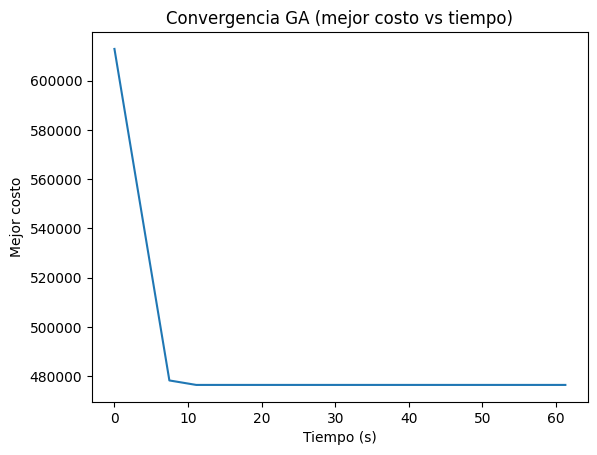

In [34]:
# Paso 3 — Celda 7: plot de convergencia (opcional)
import matplotlib.pyplot as plt

plt.figure()
plt.plot(hist["time"], hist["best_cost"])
plt.xlabel("Tiempo (s)")
plt.ylabel("Mejor costo")
plt.title("Convergencia GA (mejor costo vs tiempo)")
plt.show()


In [35]:
# Calibración: ejecutar varias configuraciones y semillas, registrar métricas

from itertools import product

def run_ga_once(params: GAParams, seed: int):
    p = copy.deepcopy(params)
    p.seed = seed
    best, hist = ga_vrp(p, verbose=False)
    m = evaluate_solution_strict(best)
    out = {
        "seed": seed,
        "best_cost": m["total_cost"],
        "vehicles": m["vehicles_used"],
        "dist_km": m["total_distance_km"],
        "time_h": m["total_time_h"],
        "iters": int(hist["gen"].max()),
        "time_sec": float(hist["time"].iloc[-1]),
    }
    return out, best, hist

def calibrate(configs: list[GAParams], seeds=(123, 456, 789)):
    rows = []
    best_by_cfg = {}
    for cfg in configs:
        tag = f"P{cfg.pop_size}_pc{cfg.pc}_pmI{cfg.pm_intra}_pmE{cfg.pm_inter}_LS{int(cfg.use_local_search)}"
        cfg_rows = []
        best_sol, best_hist = None, None
        best_val = float("inf")
        for sd in seeds:
            res, sol, hist = run_ga_once(cfg, sd)
            res["config"] = tag
            cfg_rows.append(res)
            if res["best_cost"] < best_val:
                best_val = res["best_cost"]; best_sol = sol; best_hist = hist
        best_by_cfg[tag] = (best_sol, best_hist)
        rows.extend(cfg_rows)
    df = pd.DataFrame(rows)
    agg = df.groupby("config").agg(
        runs=("best_cost","count"),
        best=("best_cost","min"),
        mean=("best_cost","mean"),
        std=("best_cost","std"),
        mean_time_s=("time_sec","mean"),
        mean_veh=("vehicles","mean"),
        mean_dist_km=("dist_km","mean")
    ).reset_index().sort_values(["mean","best"])
    return df, agg, best_by_cfg


In [37]:
# CELDA B 
from itertools import product

cfgs = []
for pop_size, pc, pm_intra, pm_inter, ls, ls_iters in product(
    [40, 60],        # pop pequeña/mediana
    [0.85, 0.90],    # cruces altos
    [0.20],          # mutación intra fija (rápido)
    [0.20],          # mutación inter fija (rápido)
    [False, True],   # probar con y sin LS
    [0, 30],         # si LS=True, pocas iteraciones
):
    # si no hay LS, ignoramos ls_iters
    use_ls = ls and (ls_iters > 0)
    cfgs.append(GAParams(
        pop_size=pop_size, pc=pc,
        pm_intra=pm_intra, pm_inter=pm_inter,
        use_local_search=use_ls, ls_iters=ls_iters,
        elite=2, max_generations=300,     # límite de generaciones bajo
        time_limit_sec=12.0,              # tope de 12 s por corrida
        tournament_k=3, seed=123
    ))

# 2 seeds -> 16 configs * 2 = 32 corridas * 12s ≈ 6.4 min máx (usualmente menos)
raw_runs, summary, best_reps = calibrate(cfgs, seeds=(123, 456))
display(summary.head(10))


,config,runs,best,mean,std,mean_time_s,mean_veh,mean_dist_km
1,P40_pc0.85_pmI0.2_pmE0.2_LS1,2,476445.1844,476445.184400,5.820766e-11,13.080356,8.0,233.170563
3,P40_pc0.9_pmI0.2_pmE0.2_LS1,2,476445.1844,476445.184400,0.000000e+00,12.895427,8.0,233.170563
7,P60_pc0.9_pmI0.2_pmE0.2_LS1,2,476445.1844,476445.184400,0.000000e+00,13.232461,8.0,233.170563
6,P60_pc0.9_pmI0.2_pmE0.2_LS0,6,476445.1844,476445.184400,0.000000e+00,12.018172,8.0,233.170563
5,P60_pc0.85_pmI0.2_pmE0.2_LS1,2,476445.1844,476445.184400,0.000000e+00,12.950995,8.0,233.170563
0,P40_pc0.85_pmI0.2_pmE0.2_LS0,6,476445.1844,482222.504272,6.328737e+03,12.026770,8.0,235.997963
2,P40_pc0.9_pmI0.2_pmE0.2_LS0,6,476445.1844,482807.669585,6.969753e+03,12.029940,8.0,236.284341
4,P60_pc0.85_pmI0.2_pmE0.2_LS0,6,476445.1844,484843.971572,9.200410e+03,12.049307,8.0,237.280900


In [39]:
import re

def parse_cfg_tag(tag: str) -> dict:
    """
    Ejemplo de tag: 'P40_pc0.85_pmI0.2_pmE0.2_LS1'
    Devuelve dict con pop_size, pc, pm_intra, pm_inter, use_local_search.
    """
    pat = r'^P(?P<pop>\d+)_pc(?P<pc>\d+(?:\.\d+)?)_pmI(?P<pmi>\d+(?:\.\d+)?)_pmE(?P<pme>\d+(?:\.\d+)?)_LS(?P<ls>[01])$'
    m = re.match(pat, tag)
    if not m:
        raise ValueError(f"Tag inesperado: {tag}")
    g = m.groupdict()
    return {
        "pop_size": int(g["pop"]),
        "pc": float(g["pc"]),
        "pm_intra": float(g["pmi"]),
        "pm_inter": float(g["pme"]),
        "use_local_search": bool(int(g["ls"])),
    }


In [40]:
# CELDA B2 (CONFIRM ≤ ~9 min) — usando el parser robusto
top3 = summary.sort_values(["mean","best","mean_time_s"]).head(3)["config"].tolist()

confirm_cfgs = []
for tag in top3:
    b = parse_cfg_tag(tag)
    confirm_cfgs.append(GAParams(
        pop_size=b["pop_size"], pc=b["pc"],
        pm_intra=b["pm_intra"], pm_inter=b["pm_inter"],
        use_local_search=b["use_local_search"], 
        ls_iters=60 if b["use_local_search"] else 0,
        elite=2, max_generations=600, time_limit_sec=45.0,
        tournament_k=3, seed=123
    ))

confirm_runs, confirm_summary, confirm_best = calibrate(confirm_cfgs, seeds=(123,456,789))
display(confirm_summary)

best_cfg_tag = confirm_summary.sort_values(["mean","best","mean_time_s"]).iloc[0]["config"]
best_sol, best_hist = confirm_best[best_cfg_tag]
m_final = evaluate_solution_strict(best_sol)
print("=== CONFIG FINAL ===", best_cfg_tag)
print(f"Vehículos: {m_final['vehicles_used']}  |  Dist(km): {m_final['total_distance_km']:.1f}  |  Costo: {int(m_final['total_cost'])}  |  t≈{best_hist['time'].iloc[-1]:.1f}s")

# Guardar tablas para el informe
raw_runs.to_csv("calibration_FAST_runs_base.csv", index=False)
summary.to_csv("calibration_FAST_summary_base.csv", index=False)
confirm_runs.to_csv("calibration_CONFIRM_runs_base.csv", index=False)
confirm_summary.to_csv("calibration_CONFIRM_summary_base.csv", index=False)
best_hist.to_csv("convergence_best_base.csv", index=False)


,config,runs,best,mean,std,mean_time_s,mean_veh,mean_dist_km
0,P40_pc0.85_pmI0.2_pmE0.2_LS1,3,476445.1844,476445.1844,0.0,45.507687,8.0,233.170563
1,P40_pc0.9_pmI0.2_pmE0.2_LS1,3,476445.1844,476445.1844,0.0,45.254660,8.0,233.170563
2,P60_pc0.9_pmI0.2_pmE0.2_LS1,3,476445.1844,476445.1844,0.0,46.252508,8.0,233.170563


=== CONFIG FINAL === P40_pc0.9_pmI0.2_pmE0.2_LS1
Vehículos: 8  |  Dist(km): 233.2  |  Costo: 476445  |  t≈45.2s


## Gráficas

In [41]:
# Punto 4 — Celda 1: utilidades para plotear rutas en mapa (lon/lat)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Diccionarios rápidos de coordenadas por ID
coord_by_id = {row.StandardizedID: (float(row.Longitude), float(row.Latitude)) 
               for _, row in clients_clean.iterrows()}
depot_row = depots.loc[depots["StandardizedID"]=="CD01"].iloc[0]
coord_by_id["CD01"] = (float(depot_row["Longitude"]), float(depot_row["Latitude"]))

def route_coords_lonlat(route_ids):
    """Devuelve listas (lons, lats) para CD01 -> ... -> CD01."""
    seq = ["CD01"] + route_ids + ["CD01"]
    lons = [coord_by_id[c][0] for c in seq]
    lats = [coord_by_id[c][1] for c in seq]
    return lons, lats

def plot_solution_routes(solution_routes, title="Rutas", ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8))
    # base: clientes y depósito
    xs = [coord_by_id[c][0] for c in clients_clean["StandardizedID"]]
    ys = [coord_by_id[c][1] for c in clients_clean["StandardizedID"]]
    ax.scatter(xs, ys, s=25, alpha=0.8, label="Clientes")
    ax.scatter([coord_by_id["CD01"][0]], [coord_by_id["CD01"][1]], s=120, marker="*", color="orange", label="Depósito")

    # rutas
    for ridx, r in enumerate(solution_routes, start=1):
        lons, lats = route_coords_lonlat(r)
        ax.plot(lons, lats, linewidth=2, alpha=0.9)
        # etiqueta en el primer cliente de la ruta
        if r:
            cx, cy = coord_by_id[r[0]]
            ax.text(cx, cy, f"R{ridx}", fontsize=9, color="black")

    ax.set_xlabel("Longitud"); ax.set_ylabel("Latitud")
    ax.set_title(title)
    ax.legend()
    ax.grid(alpha=0.3)
    plt.show()


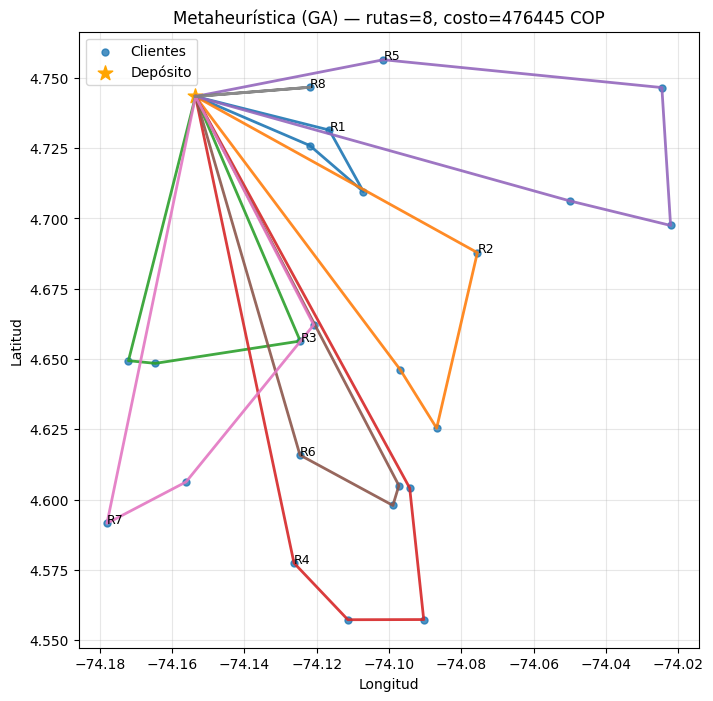

In [42]:
# Punto 4 — Celda 2: mapa de rutas del GA
assert_feasible(best_ga, Q, clients_clean)
m_best = evaluate_solution_strict(best_ga)
plot_solution_routes(best_ga, title=f"Metaheurística (GA) — rutas={m_best['vehicles_used']}, costo={int(m_best['total_cost'])} COP")


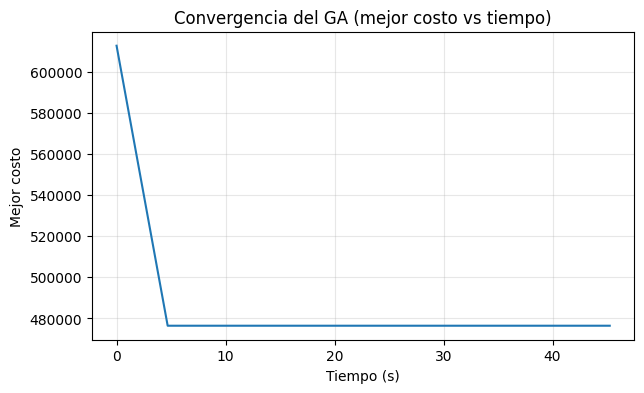

In [43]:
# Punto 4 — Celda 3: curva de convergencia (usa 'hist' o 'best_hist' según nombraste arriba)
conv_df = best_hist if 'best_hist' in globals() else hist
plt.figure(figsize=(7,4))
plt.plot(conv_df["time"], conv_df["best_cost"])
plt.xlabel("Tiempo (s)")
plt.ylabel("Mejor costo")
plt.title("Convergencia del GA (mejor costo vs tiempo)")
plt.grid(alpha=0.3)
plt.show()


In [45]:
# Punto 4 — Celda 5: comparación de métricas (GA vs Pyomo) con la MISMA FO

def eval_solution_dict(solution_routes: list[list[str]]) -> dict:
    m = evaluate_solution_strict(solution_routes)
    return {
        "vehicles": m["vehicles_used"],
        "distance_km": m["total_distance_km"],
        "time_h": m["total_time_h"],
        "fuel_cop": m["fuel_cost_cop"],
        "total_cost_cop": m["total_cost"]
    }

# Cargar Pyomo (si ya tienes el archivo)
pyomo_routes = None
if Path(PYOMO_ROUTES_CSV).exists():
    pyomo_routes = load_routes_csv(PYOMO_ROUTES_CSV)
    assert_feasible(pyomo_routes, Q, clients_clean)

res_ga = eval_solution_dict(best_ga)
res_pyomo = eval_solution_dict(pyomo_routes) if pyomo_routes is not None else None

comp_rows = [{"metric":"vehicles","GA":res_ga["vehicles"], "Pyomo": (res_pyomo["vehicles"] if res_pyomo else None)},
             {"metric":"distance_km","GA":res_ga["distance_km"], "Pyomo": (res_pyomo["distance_km"] if res_pyomo else None)},
             {"metric":"time_h","GA":res_ga["time_h"], "Pyomo": (res_pyomo["time_h"] if res_pyomo else None)},
             {"metric":"fuel_cop","GA":res_ga["fuel_cop"], "Pyomo": (res_pyomo["fuel_cop"] if res_pyomo else None)},
             {"metric":"total_cost_cop","GA":res_ga["total_cost_cop"], "Pyomo": (res_pyomo["total_cost_cop"] if res_pyomo else None)}]
comp_df = pd.DataFrame(comp_rows)
display(comp_df)


,metric,GA,Pyomo
0,vehicles,8.000000,None
1,distance_km,233.170563,None
2,time_h,9.326823,None
3,fuel_cop,126689.339408,None
4,total_cost_cop,476445.184400,None


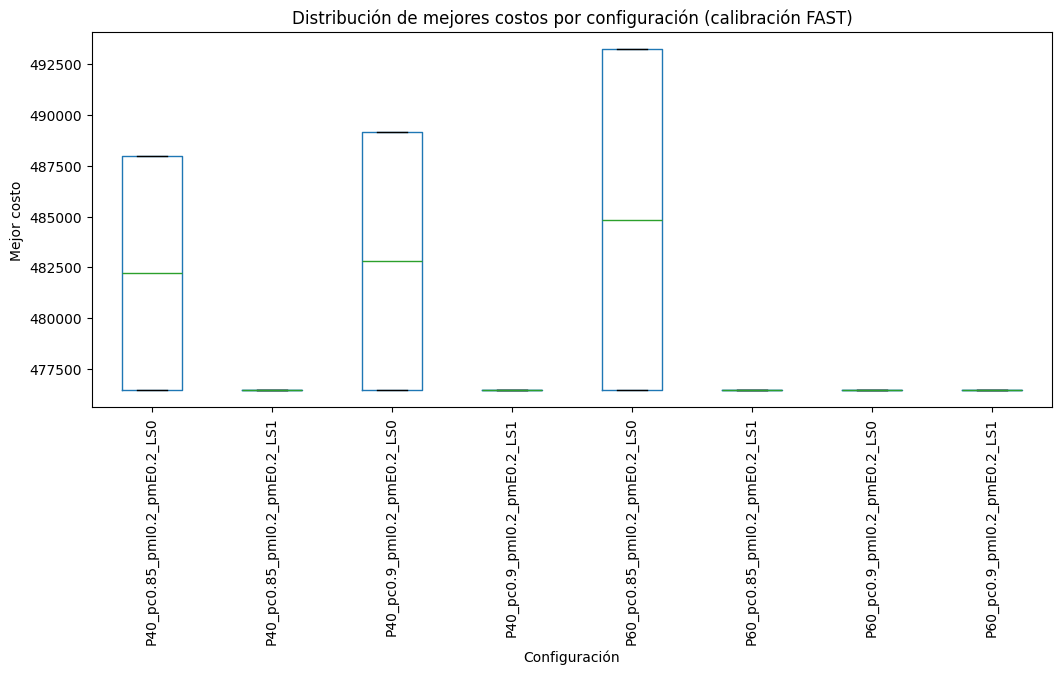

In [47]:
# Punto 4 — Celda 7 (opcional): distribución de resultados de calibración
if 'raw_runs' in globals():
    tmp = raw_runs.copy()
    ax = tmp.boxplot(column="best_cost", by="config", grid=False, rot=90, figsize=(12,5))
    plt.title("Distribución de mejores costos por configuración (calibración FAST)"); plt.suptitle("")
    plt.xlabel("Configuración"); plt.ylabel("Mejor costo")
    plt.show()
